                                                                                                   
#### Author: Randy Bukasa

This analysis will attempt to forecast demand for  provided products.

Motivation:

Building a predective forecasting model will allow  to make recommendations in order to fulfull business objectives such as improved financial planning, accurate procurement strategies and efficient product pricing.

In [283]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import statsmodels.api as sm
import matplotlib
import seaborn as sns
from datetime import datetime
plt.rcParams['figure.figsize'] = (15,3)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [284]:
# Read in order data and external inflation data
order_data = pd.read_csv('product_order_data.csv')
inflation_data = pd.read_csv('OECD_inflation_forecast.csv')

In [285]:
order_data.head()

,order_placement_date,requested_delivery_date,order_delivery_date,order_quantity,quantity_unit,product_name,material_id,country,origin_region,warehouse_names,company_id,order_id
0,2020-08-13,2020-09-08,2020-09-08,1000.000,KG,Citric Acid,E235421,United Kingdom,EU,Lutterworth,COER82357,23c60cjbmuvhgqk820ps
1,2020-09-15,2020-09-22,2020-09-22,100.000,KG,Citric Acid,E235421,United Kingdom,EU,Bristol,COIU94847,5i5ftojtbpgt9967st8l
2,2020-04-02,2020-06-02,2020-06-02,2196.000,KG,Gelatin,E164938,The Netherlands,APAC,Enschede,COVQ64536,i72w4oebmqpjbmwmnohg
3,2019-09-16,2019-09-19,2019-09-19,25.000,KG,Citric Acid,E235421,United Kingdom,EU,Bristol,COBE05528,3vtl1drz0xv6ddd27d9a
4,2019-06-13,2019-08-01,2019-08-01,2000000.000,G,Citric Acid,E235421,United Kingdom,EU,Bristol,COQZ30137,lk7ybzgazni37zcgacep


Columns:

**order_id** - identifier of order  
**order placement date** - date the order was placed at   
**requested delivery date** - date requested by the customer for the order to be delivered
**order delivery date** - actual delivery date  
**order quantity** - amount that was ordered, unit is specified in other column  
**quantity unit** - unit for the order quantity  
**product name** - product name  
**product_id** - product id  
**country** -  operating country for the order  
**origin_region** - Either EU or APAC - some products are sourced from manufacturers in the APAC region. These orders have a longer lead time of up to 90 days. For the EU these lead times are usually under 14 days  
**warehouse** - Warehouse from which the order was fulfilled  
**company_id** - id of customer company placing the order at 


In [286]:
inflation_data.head()

,country,year,quarter,month_in_quarter,mapping_key,month_num,month_name,start_of_month,inflation
0,FR,2016,Q3,Q-M1,Q3-Q-M1,7,July,1-7-2016,0.000
1,FR,2016,Q3,Q-M2,Q3-Q-M2,8,August,1-8-2016,0.000
2,FR,2016,Q3,Q-M3,Q3-Q-M3,9,September,1-9-2016,0.000
3,FR,2016,Q4,Q-M1,Q4-Q-M1,10,October,1-10-2016,0.795
4,FR,2016,Q4,Q-M2,Q4-Q-M2,11,November,1-11-2016,1.041


In [287]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8364 entries, 0 to 8363
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_placement_date     8364 non-null   object 
 1   requested_delivery_date  8364 non-null   object 
 2   order_delivery_date      8364 non-null   object 
 3   order_quantity           8364 non-null   float64
 4   quantity_unit            8364 non-null   object 
 5   product_name             8364 non-null   object 
 6   material_id              8364 non-null   object 
 7   country                  8364 non-null   object 
 8   origin_region            8364 non-null   object 
 9   warehouse_names          8364 non-null   object 
 10  company_id               8364 non-null   object 
 11  order_id                 8364 non-null   object 
dtypes: float64(1), object(11)
memory usage: 784.2+ KB


In [288]:
inflation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           270 non-null    object 
 1   year              270 non-null    int64  
 2   quarter           270 non-null    object 
 3   month_in_quarter  270 non-null    object 
 4   mapping_key       270 non-null    object 
 5   month_num         270 non-null    int64  
 6   month_name        270 non-null    object 
 7   start_of_month    270 non-null    object 
 8   inflation         270 non-null    float64
dtypes: float64(1), int64(2), object(6)
memory usage: 19.1+ KB


In [289]:
# change all date columns to date format, easier to run EDA
order_data.iloc[:,:3] = order_data.iloc[:,:3].apply(pd.to_datetime, errors = 'coerce')
inflation_data['start_of_month'] = pd.to_datetime(inflation_data['start_of_month'], format='%d-%m-%Y' )

- notices is that order may not be done on a daily basis, may need to aggregate data on periodic basis e.g., weekly, monthly, etc...
- match the two files on country of supplier  and dates
- multiple units of measurements per product
- dates for the two files do not match, will need to resample

In [290]:
# find length of data
print('The min for order is:', order_data.order_placement_date.min(), 'and the max is:', order_data.order_placement_date.max())

The min for order is: 2017-01-02 00:00:00 and the max is: 2022-12-09 00:00:00


In [291]:
# find length of data
print('The min for order is:', inflation_data.start_of_month.min(), 'and the max is:', inflation_data.start_of_month.max())

The min for order is: 2016-07-01 00:00:00 and the max is: 2023-12-01 00:00:00


In [292]:
#lets clean the data by standardizing the unit of meaure into kilograms, reason being kilograms are between both grams 
# and megatons, and majority of orders are made in kilograms
order_data['order_quantity'] = np.where(order_data['quantity_unit'] == 'G', order_data['order_quantity']/1000,
                                      (np.where(order_data['quantity_unit'] == 'MT', order_data['order_quantity']*1000, order_data['order_quantity'])))

#### Lead Times

Information given states lead times for APAC 90 days vs EU at 14 days

In [293]:
# lets create a column to calcualate lead in days
order_data['delivery_time_days'] = (order_data['order_delivery_date'] - order_data['order_placement_date']).dt.days
order_data['lead_time_days'] = np.where(order_data['origin_region'] == 'EU',14,90)



# Lets also create late order colunm, this will help us mitigate late deliveries, so we order ealier 
order_data['late_delivery_days'] = (order_data['order_delivery_date'] - order_data['requested_delivery_date']).dt.days

In [294]:
order_data.groupby(['product_name'])['delivery_time_days'].describe()

,count,mean,std,min,25%,50%,75%,max
product_name,,,,,,,,
Citric Acid,3398.000,15.034,27.477,0.000,5.000,7.000,15.000,373.000
Gelatin,2992.000,13.009,22.066,0.000,3.000,5.000,11.000,336.000
Sugar,1974.000,25.580,46.168,0.000,5.000,8.000,25.000,585.000


In [295]:
order_data.groupby(['product_name'])['lead_time_days'].describe()

,count,mean,std,min,25%,50%,75%,max
product_name,,,,,,,,
Citric Acid,3398.000,14.000,0.000,14.000,14.000,14.000,14.000,14.000
Gelatin,2992.000,90.000,0.000,90.000,90.000,90.000,90.000,90.000
Sugar,1974.000,14.000,0.000,14.000,14.000,14.000,14.000,14.000


In [296]:
order_data.groupby(['origin_region'])['product_name'].unique()

origin_region
APAC               [Gelatin]
EU      [Citric Acid, Sugar]
Name: product_name, dtype: object

In [297]:
# count of late order as percentage of all order per product
order_data['late_order_count'] = np.where(order_data['late_delivery_days'] > 0, 1,0)
late_ratio = order_data.groupby(['product_name'])['late_order_count'].sum() /order_data['product_name'].value_counts().tolist()

**Assumptions & Insights**

1. From information provided we have estimated that the only product imported from APAC is gelatin with a lead time of 90 days
2. There are 2 products from EU citric acid & Sugar with an average of 14 days
3. In addition to the above lead times, there is delivery time from  warehouse to customer which varies as shown above
4. Finally there are some orders which are delivered later than requested by customers. 

To build a model we would need to cater for all the above on a per product basis to have more accurate estimates of when to ship and how much.

In [298]:
# create lead times for all products
lead_df = order_data.groupby(['product_name']).agg({'lead_time_days':'mean'})

lead_df['delivery_time'] = order_data.groupby(['product_name'])['delivery_time_days'].describe().reset_index()['75%'].tolist()
lead_df['late_ratio'] = late_ratio
lead_df['total_lead'] = (lead_df['delivery_time'] + lead_df['lead_time_days']) * (1+lead_df['late_ratio'])
lead_df

,lead_time_days,delivery_time,late_ratio,total_lead
product_name,,,,
Citric Acid,14.000,15.000,0.097,31.799
Gelatin,90.000,11.000,0.059,106.975
Sugar,14.000,25.000,0.047,40.837


In [299]:
# create variables for each product's lead time in days
citric_acid_lead = lead_df.loc['Citric Acid']['total_lead']
gelatin_acid_lead = lead_df.loc['Gelatin']['total_lead']
sugar_acid_lead = lead_df.loc['Sugar']['total_lead']

In [300]:
# How frequent does the average customer order and for how much
df_customer = order_data.groupby(['company_id', 'product_name']).agg({'order_placement_date':['min','max'],
                                                                      'order_id': 'nunique',
                                                                     'order_quantity':'sum'}).reset_index()

df_customer.columns = df_customer.columns.map('_'.join)
df_customer['days_since_first'] = df_customer['order_placement_date_max'] - df_customer['order_placement_date_min']
df_customer['average_days_between'] = df_customer['days_since_first'] / df_customer['order_id_nunique']
df_customer['average_order_quantity'] = df_customer['order_quantity_sum'] / df_customer['order_id_nunique']
df_customer.groupby('product_name_')['average_days_between'].describe()

,count,mean,std,min,25%,50%,75%,max
product_name_,,,,,,,,
Citric Acid,616,132 days 08:39:39.209715766,166 days 14:10:57.205099480,0 days 00:00:00,0 days 00:00:00,72 days 11:20:00,199 days 02:15:00,885 days 12:00:00
Gelatin,216,75 days 20:54:15.703760390,102 days 23:39:25.627485452,0 days 00:00:00,0 days 00:00:00,39 days 06:13:50.769230769,107 days 13:09:28.421052632,651 days 12:00:00
Sugar,261,151 days 21:24:33.843500448,156 days 15:56:09.148288730,0 days 00:00:00,23 days 08:00:00,108 days 08:28:14.117647058,224 days 00:00:00,878 days 12:00:00


Most customers only order once a quarter on average. one can even predict on a per customer level if we can find out how much they demand wnd for which product.

In [ ]:
# See if customers order multiple products from  - no granger causality for this attempt
df_customer.groupby(['company_id_'])['product_name_'].nunique().mean()

1.0186393289841567

#### Inflation has impact???

In [302]:
#  get distribution of sales per product per country
df_distr = order_data.groupby(['country', 'product_name'])['order_quantity'].sum().reset_index()

total = df_distr.groupby(['product_name'])['order_quantity'].transform('sum')

df_distr['% of product'] = df_distr['order_quantity'].div(total)
df_distr

,country,product_name,order_quantity,% of product
0,France,Gelatin,1817300.000,0.282
1,France,Sugar,1088000.000,0.393
2,The Netherlands,Citric Acid,977125.000,0.103
3,The Netherlands,Gelatin,4633974.223,0.718
4,United Kingdom,Citric Acid,8536467.603,0.897
5,United Kingdom,Sugar,1682931.500,0.607


In [303]:
# France demand distribution
france_gelatine_ratio = df_distr[(df_distr['country'] == "France") & (df_distr['product_name'] == "Gelatin") ]['% of product'].item()
france_sugar_ratio = df_distr[(df_distr['country'] == "France") & (df_distr['product_name'] == "Sugar") ]['% of product'].item()

# Netherlands demand distribution
neds_citric_ratio = df_distr[(df_distr['country'] == "The Netherlands") & (df_distr['product_name'] == "Citric Acid") ]['% of product'].item()
neds_gelatin_ratio = df_distr[(df_distr['country'] == "The Netherlands") & (df_distr['product_name'] == "Gelatin") ]['% of product'].item()

# UK demand distribution
uk_citric_ratio = df_distr[(df_distr['country'] == "United Kingdom") & (df_distr['product_name'] == "Citric Acid") ]['% of product'].item()
uk_sugar_ratio = df_distr[(df_distr['country'] == "United Kingdom") & (df_distr['product_name'] == "Sugar") ]['% of product'].item()

In [304]:
# Change countries in inflation
inflation_data['country'].replace({'FR': 'France',
                                  'NL':'The Netherlands',
                                  'UK': 'United Kingdom'}, inplace=True)

In [305]:
# extract year month for merging
order_data['year_month'] =  order_data.order_placement_date.dt.to_period('M')
inflation_data['year_month'] =  inflation_data.start_of_month.dt.to_period('M')

In [306]:
# create df for all products resampled by lead time
df_citric = order_data[order_data['product_name'] == 'Citric Acid'][['order_placement_date', 'order_quantity', 'year_month']]
df_citric = df_citric.set_index('order_placement_date').resample(round(citric_acid_lead,0).astype(int).astype(str) + 'D')\
.agg({'order_quantity':'sum',
     'year_month':'mean'})

df_gelatin = order_data[order_data['product_name'] == 'Gelatin'][['order_placement_date', 'order_quantity', 'year_month']]
df_gelatin = df_gelatin.set_index('order_placement_date').resample(round(gelatin_acid_lead,0).astype(int).astype(str) + 'D')\
.agg({'order_quantity':'sum',
     'year_month':'mean'})

df_sugar = order_data[order_data['product_name'] == 'Sugar'][['order_placement_date', 'order_quantity', 'year_month']]
df_sugar = df_sugar.set_index('order_placement_date').resample(round(sugar_acid_lead,0).astype(int).astype(str) + 'D')\
.agg({'order_quantity':'sum',
     'year_month':'mean'})

In [307]:
# Create dataframe for only gelatin related importing countries (France & Netherlands)

df_gelatin = df_gelatin.reset_index()

gelatin_inflation = inflation_data[inflation_data['country'].isin(['France', 'The Netherlands'])].pivot_table(index='year_month', columns='country', values='inflation')

# adjust inlfation distribution based on gelatin demand France & Netherlands 
gelatin_inflation['balanced_inflation'] = (gelatin_inflation['France']*france_gelatine_ratio) + (gelatin_inflation['The Netherlands']*neds_gelatin_ratio)

gelatin_inflation = gelatin_inflation.reset_index()
df_gelatin = df_gelatin.merge(gelatin_inflation[['year_month', 'balanced_inflation']], on='year_month', how='left')
df_gelatin = df_gelatin.set_index('order_placement_date')
df_gelatin.drop('year_month', axis=1, inplace=True)

In [308]:
# Create dataframe for only gelatin related importing countries (UK & Netherlands)

df_citric = df_citric.reset_index()

citric_inflation = inflation_data[inflation_data['country'].isin(['United Kingdom', 'The Netherlands'])].pivot_table(index='year_month', columns='country', values='inflation')

# adjust inlfation distribution based on gelatin demand France & Netherlands 
citric_inflation['balanced_inflation'] = (citric_inflation['United Kingdom']*uk_citric_ratio) + (citric_inflation['The Netherlands']*neds_citric_ratio)

citric_inflation = citric_inflation.reset_index()
df_citric = df_citric.merge(citric_inflation[['year_month', 'balanced_inflation']], on='year_month', how='left')
df_citric = df_citric.set_index('order_placement_date')
df_citric.drop('year_month', axis=1, inplace=True)

In [309]:
# Create dataframe for only gelatin related importing countries (UK & France)

df_sugar = df_sugar.reset_index()

sugar_inflation = inflation_data[inflation_data['country'].isin(['United Kingdom', 'France'])].pivot_table(index='year_month', columns='country', values='inflation')

# adjust inlfation distribution based on gelatin demand France & Netherlands 
sugar_inflation['balanced_inflation'] = (sugar_inflation['United Kingdom']*uk_sugar_ratio) + (sugar_inflation['France']*france_sugar_ratio)

sugar_inflation = sugar_inflation.reset_index()
df_sugar = df_sugar.merge(sugar_inflation[['year_month', 'balanced_inflation']], on='year_month', how='left')
df_sugar = df_sugar.set_index('order_placement_date')
df_sugar.drop('year_month', axis=1, inplace=True)

**Outliers:**
As displayed above, there are definitely outliers to look out for. These may be unintentional errors, but extreme. We will soften them by identifying them then smoothing them interpolate/linear values.

**Missing**
We will take a similar approach to fill in missing values to not lose any vital information.

In [310]:
#Make extreme outliers null then we can interpolate/smoothen
df_gelatin['order_quantity'] = np.where(df_gelatin['order_quantity'] < df_gelatin['order_quantity'].quantile(0.00001), np.nan,
         (np.where(df_gelatin['order_quantity'] > df_gelatin['order_quantity'], np.nan, df_gelatin['order_quantity'] )))


df_sugar['order_quantity'] = np.where(df_sugar['order_quantity'] < df_sugar['order_quantity'].quantile(0.00001), np.nan,
         (np.where(df_sugar['order_quantity']> df_sugar['order_quantity'].quantile(0.999), np.nan, df_sugar['order_quantity'] )))

df_citric['order_quantity'] = np.where(df_citric['order_quantity'] < df_citric['order_quantity'].quantile(0.00001), np.nan,
         (np.where(df_citric['order_quantity'] > df_citric['order_quantity'].quantile(0.999), np.nan, df_citric['order_quantity'] )))

<a id='Correlation_Analysis'></a>
**Stationarity**

Staionarity can be defined as the statistical properties of a process generating a time series do not change over time. With the data being stationary, one is able to make more accurate estimates about the data as there is less variability.

Properties of stationary data:

1) It should have a constant mean

2) It should have a constant variance

3) Auto covariance does not depend on the time

*Mean – it is the average value of all the data

*Variance – it is a difference of each point value from the mean

*Auto covariance –it is a relationship between any two values at a certain amount of time.

 

Method to check the stationarity of the Time Series Data:-
There are two methods in python to check data stationarity:-

**Augmented Dickey- fuller Test (ADCF):**

This test will provides us results to check stationarity. The null huypothesis is that the time series are not stationary if certain conditions are not met. 

1. p-value < the alpha(0.05%) = Stationarity
2. Test Statistic < critical values =  Stationarity

In [311]:
df_gelatin['order_quantity'].fillna(df_gelatin['order_quantity'].mean(), inplace=True)
df_sugar['order_quantity'].fillna(df_sugar['order_quantity'].mean(), inplace=True)
df_citric['order_quantity'].fillna(df_citric['order_quantity'].mean(), inplace=True)

In [312]:
from statsmodels.tsa.stattools import adfuller
print('Observations of Dickey-fuller test')
dftest = adfuller(df_gelatin['order_quantity'],autolag='AIC')
dfoutput_acid=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput_acid['critical value (%s)'%key]= value
print(dfoutput_acid)

Observations of Dickey-fuller test
Test Statistic                -5.759
p-value                        0.000
#lags used                     8.000
number of observations used   12.000
critical value (1%)           -4.138
critical value (5%)           -3.155
critical value (10%)          -2.714
dtype: float64


In [313]:
from statsmodels.tsa.stattools import adfuller
print('Observations of Dickey-fuller test')
dftest = adfuller(df_sugar['order_quantity'],autolag='AIC')
dfoutput_gelatin=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput_gelatin['critical value (%s)'%key]= value
print(dfoutput_gelatin)

Observations of Dickey-fuller test
Test Statistic                -7.068
p-value                        0.000
#lags used                     0.000
number of observations used   52.000
critical value (1%)           -3.563
critical value (5%)           -2.919
critical value (10%)          -2.597
dtype: float64


In [314]:
from statsmodels.tsa.stattools import adfuller
print('Observations of Dickey-fuller test')
dftest = adfuller(df_citric['order_quantity'],autolag='AIC')
dfoutput_sugar=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput_sugar['critical value (%s)'%key]= value
print(dfoutput_sugar)

Observations of Dickey-fuller test
Test Statistic                -7.073
p-value                        0.000
#lags used                     0.000
number of observations used   67.000
critical value (1%)           -3.532
critical value (5%)           -2.906
critical value (10%)          -2.590
dtype: float64


The ADF test suggests that the p-value is extremely small and the Test Statistic is less than all the critical values mentioned in the test. We can coclude that the means, median is consistent through time and would be sufficient to build a model. Next we will try to establish if there is seasonality. This will enable us to determine what type of algorithm is best suited for forecasting this dataset.

***Seasonality & trends***

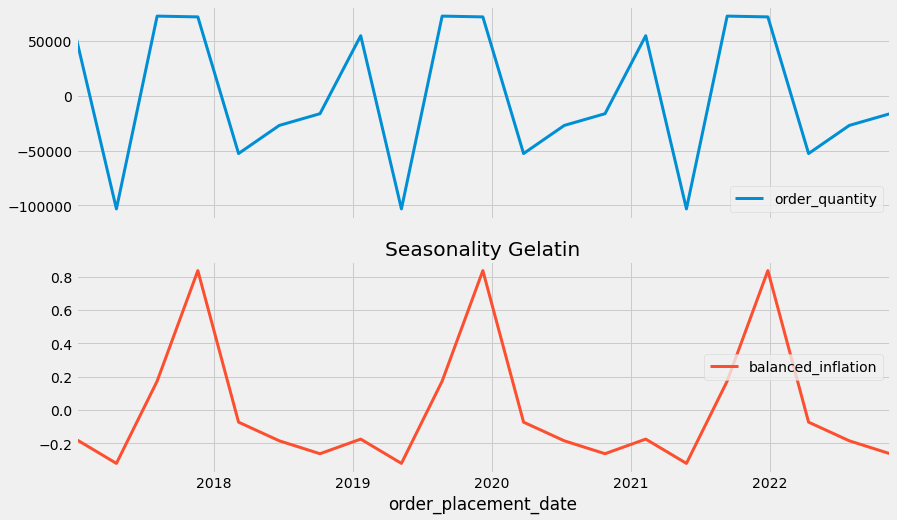

In [315]:
# visualize seasonality
seasonality_dict = {}

for demand in df_gelatin.columns:
    decompositions = sm.tsa.seasonal_decompose(df_gelatin[demand] , model='additive')
    
    seasonality_dict[demand] = decompositions.seasonal
    

# Plot
plt.rcParams['figure.figsize'] = 13, 8
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(2, 1), linewidth=3,);
plt.title('Seasonality Gelatin')
plt.show()

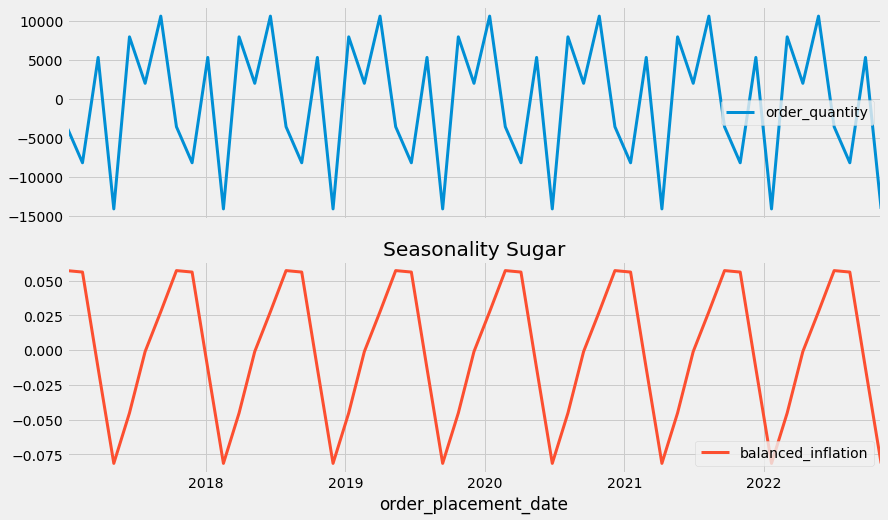

In [316]:
# visualize seasonality
seasonality_dict = {}

for demand in df_sugar.columns:
    decompositions = sm.tsa.seasonal_decompose(df_sugar[demand] , model='additive')
    
    seasonality_dict[demand] = decompositions.seasonal
    

# Plot
plt.rcParams['figure.figsize'] = 13, 8
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(2, 1), linewidth=3,);
plt.title('Seasonality Sugar')
plt.show()

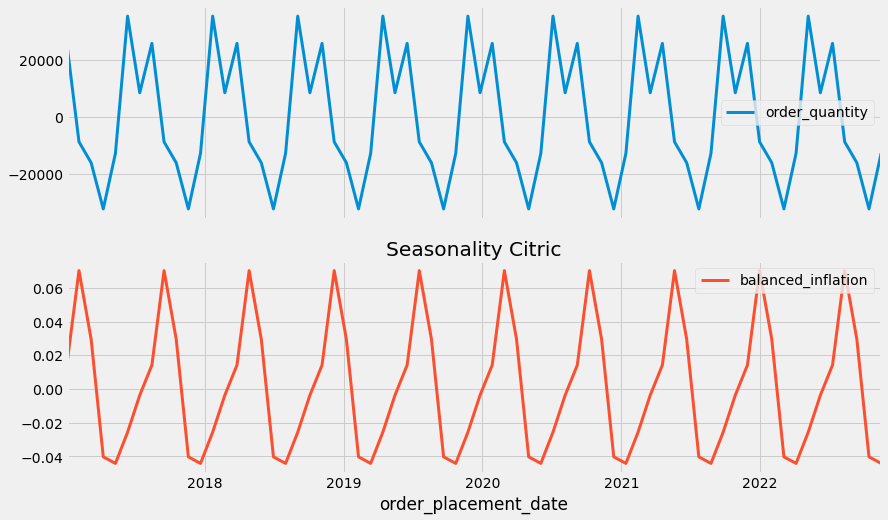

In [317]:
# visualize seasonality
seasonality_dict = {}

for demand in df_citric.columns:
    decompositions = sm.tsa.seasonal_decompose(df_citric[demand] , model='additive')
    
    seasonality_dict[demand] = decompositions.seasonal
    

# Plot
plt.rcParams['figure.figsize'] = 13, 8
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(2, 1), linewidth=3,);
plt.title('Seasonality Citric')
plt.show()

from the above visualization it is apparent that there are cycle on a per annum basis. 

- Citric acid start every period with relatively low demand but steadily climbs and peak around the last quarter of the year.Also seems to be slightly correlated with inflation in relative countries. We can assume that citric acid demand is not sensitive to increases in price 

- Gelatin starts every period with high levels of orders, declines during the next two quarters then a final two peak in the last quarter. Has a negative correlation with inflation in relative countries, suggestive of sensitivity to price increases.

- Sugar's demand is quite volitile many peak and trogh through a period. Also shows slight negative correlation to inflation.

In [318]:
order_data2 = order_data.pivot_table(index='order_placement_date',
                                     columns= 'product_name',aggfunc=({'order_quantity': 'sum'}), fill_value=0)
order_data2.columns = order_data2.columns.map('_'.join)
order_data2 = order_data2.resample('MS', convention='start', label='left', closed='left').sum()

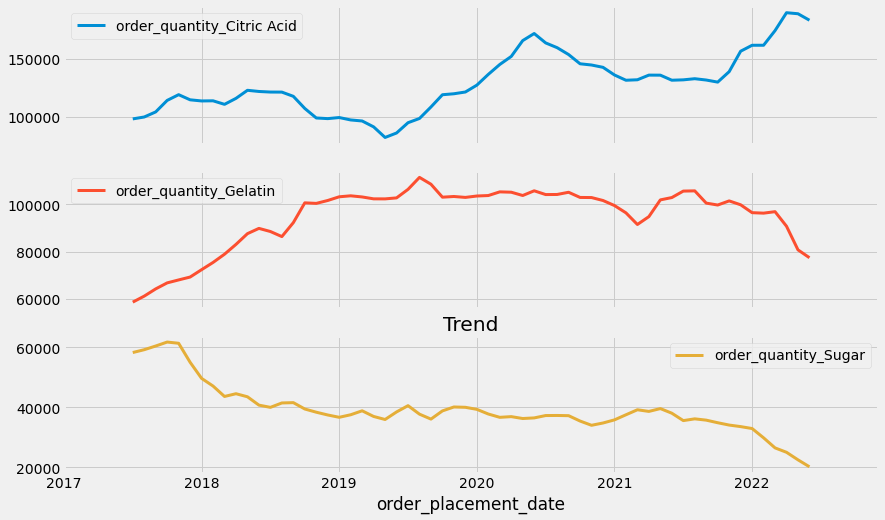

In [319]:
# visualize seasonality
trend_dict = {}

for demand in order_data2.columns:
    decompositions = sm.tsa.seasonal_decompose(order_data2[demand] , model='additive')

    trend_dict[demand] = decompositions.trend
    

# Plot
plt.rcParams['figure.figsize'] = 13, 8
pd.DataFrame(trend_dict).plot(subplots=True, layout=(3, 1), linewidth=3,);
plt.title('Trend')
plt.show()

- Citric acid grows from strength to strength with year on year growth.
- Gelatine has also been on a steady decline after 2021, could be partly associated with it's sugar complimentary products where demand has been slowing down
- Not suprisingly demand for sugar is declining year by year has consumer's in the food industry become more health conscious

In [320]:
df_citric.rename(columns={'balanced_inflation': 'citric_inflation'}, inplace=True)
df_sugar.rename(columns={'balanced_inflation': 'sugar_inflation'}, inplace=True)
df_gelatin.rename(columns={'balanced_inflation': 'gelatin_inflation'}, inplace=True)

**Autocorrelation:**

Autocorrelation measures the degree of similarity between a time series and a lagged version of itself over successive time intervals. This is useful because it informs us on the quantity of lags to consider for prediction.

ACF explains how the present value of a given time series is correlated with the past (1-unit past, 2-unit past, …, n-unit past) values. In the ACF plot, the x-axis expresses the correlation coefficient whereas the y-axis mentions the number of lags.

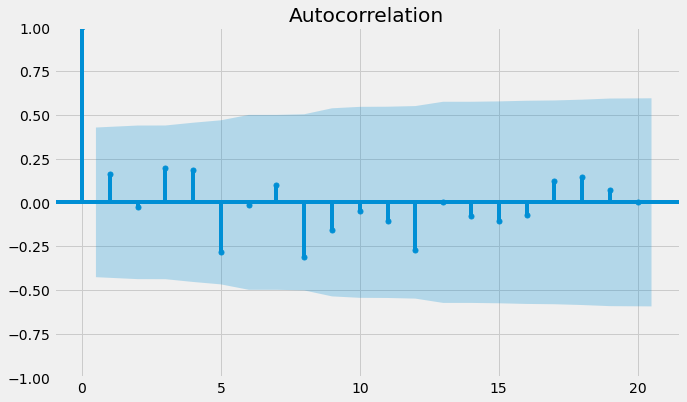

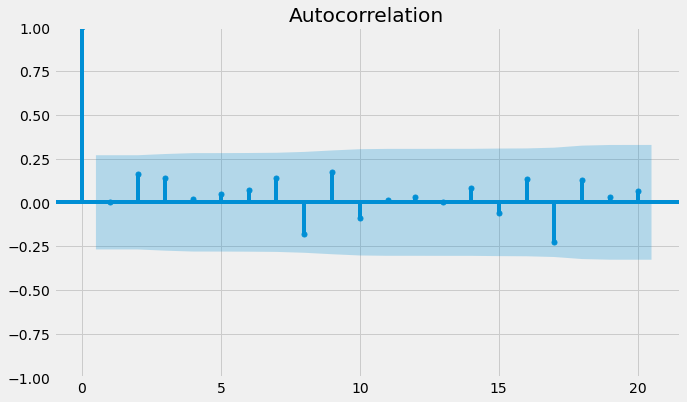

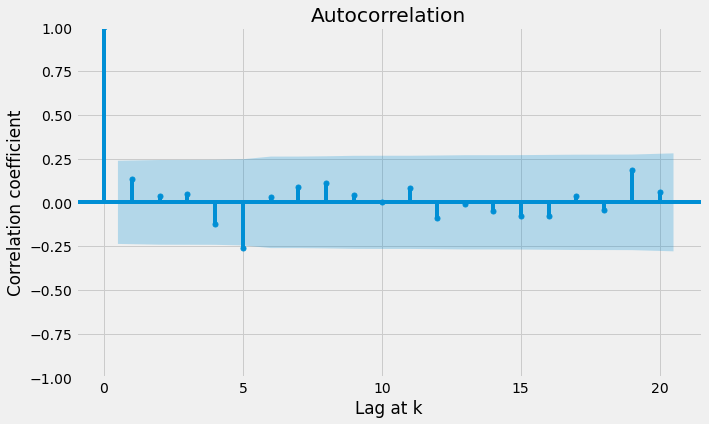

In [321]:
#Evaluate MA with ACF
from statsmodels.graphics import tsaplots

# plt.subplot(3, 1, 1)
plt.rcParams['figure.figsize'] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig1 = tsaplots.plot_acf(df_gelatin['order_quantity'], lags=20)
fig2 = tsaplots.plot_acf(df_sugar['order_quantity'], lags=20)
fig3 = tsaplots.plot_acf(df_citric['order_quantity'], lags=20)

plt.xlabel('Lag at k')
plt.ylabel('Correlation coefficient')
plt.show()

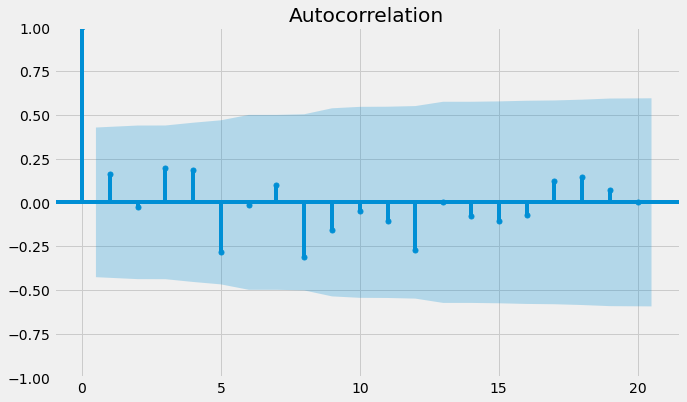

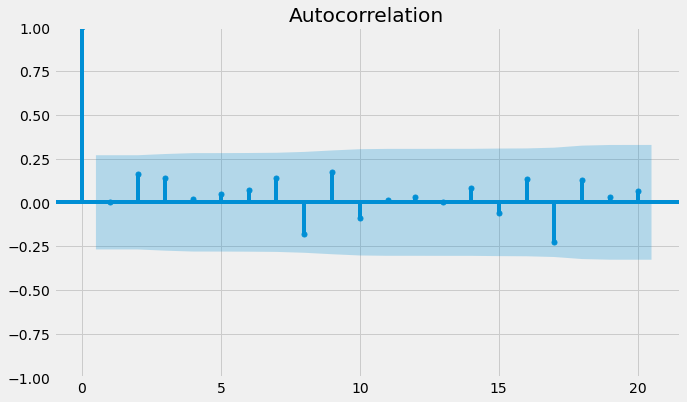

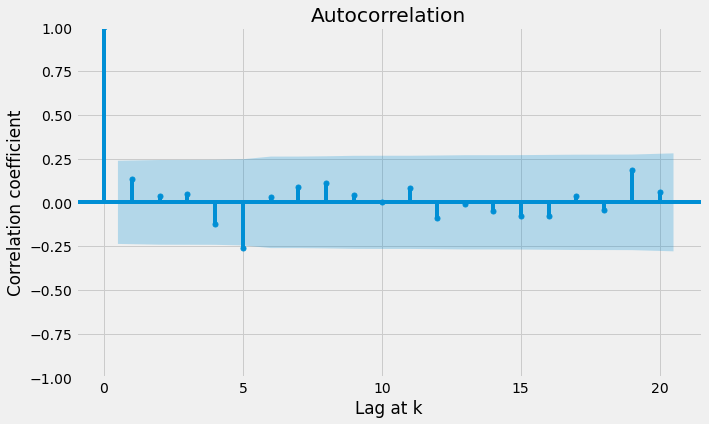

In [322]:
# PACF evaluate autoregressive part of P (p,d,q) for ingredient

# plt.subplot(3, 1, 1)
plt.rcParams['figure.figsize'] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig1 = tsaplots.plot_acf(df_gelatin['order_quantity'], lags=20)
fig2 = tsaplots.plot_acf(df_sugar['order_quantity'], lags=20)
fig3 = tsaplots.plot_acf(df_citric['order_quantity'], lags=20)

plt.xlabel('Lag at k')
plt.ylabel('Correlation coefficient')
plt.show()

PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself. In simple terms, PACF can be explained using a linear regression where we predict y(t) from y(t-1), y(t-2), and y(t-3)

#### Model Building

#### Citric Acid

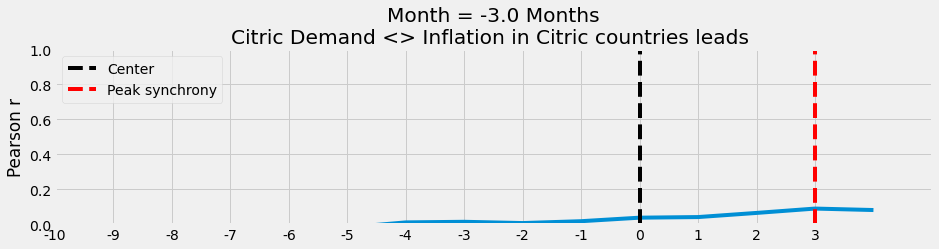

In [323]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df_citric['citric_inflation']
d2 = df_citric['order_quantity']

rs = [crosscorr(d1,d2, lag) for lag in range(-int(5),int(5))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Month = {offset} Months\nCitric Demand <> Inflation in Citric countries leads ',ylim=[0,1],xlim=[0,10],ylabel='Pearson r')
ax.set_xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,])
# ax.set_yticks([1,0.8,0.6,0.4,0.2,0]);
plt.legend()
plt.show()

In the plot above, it would appear that demand lead for citric acid demand, it may be that the price of citric acid increases and is one of the items directly impacting inflation. Also unlike gelatin, the trend for citric acid seem to growing over time. 

In [324]:
#As discussed above, create a new feature from lagging leading oil price by 3 months
df_citric['citric_inflation_lagged'] = df_citric['citric_inflation'].shift(3)
df_citric.dropna(inplace=True)

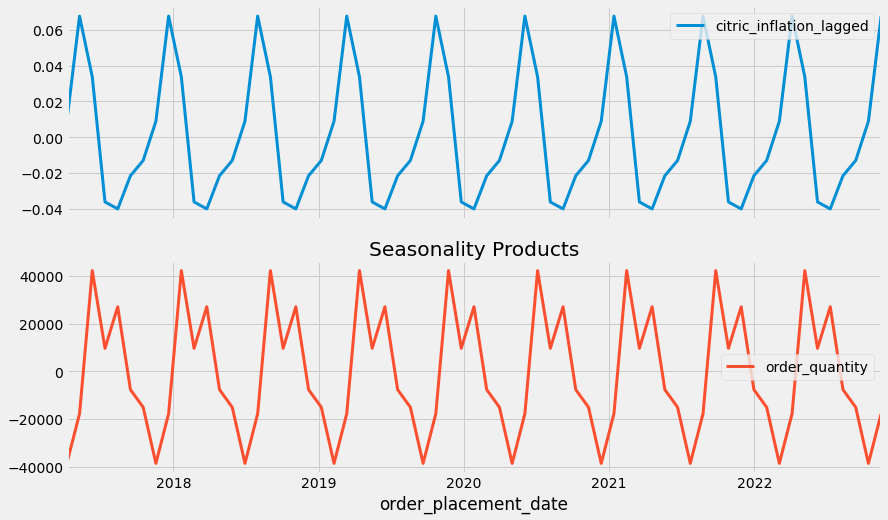

In [325]:
# visualize seasonality
seasonality_dict = {}

for demand in df_citric[['citric_inflation_lagged', 'order_quantity']].columns:
    decompositions = sm.tsa.seasonal_decompose(df_citric[demand] , model='additive')
    # Store the results back
    seasonality_dict[demand] = decompositions.seasonal
    

# Plot
plt.rcParams['figure.figsize'] = 13, 8
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(2, 1), linewidth=3,);
plt.title('Seasonality Products')
plt.show()

In [326]:
# Lagging the time series by 1, provide view just using past month as a predictor
df_base = pd.concat([df_citric['order_quantity'], df_citric['order_quantity'].shift(1)], axis=1)
df_base.columns = ['actual_demand', 'forecast_demand']
df_base.dropna(inplace=True)

from sklearn.metrics import mean_squared_error

# Use mean squared error to evaluate accuracy 
mse = ((df_base['actual_demand']['2022-06-09':] - df_base['forecast_demand']['2022-06-09':]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)), '. Let us proceed with alternative model')

The Mean Squared Error of our forecasts is 16707337553.29
The Root Mean Squared Error of our forecasts is 129256.87 . Let us proceed with alternative model


In [327]:
# Hyperparameter tuning to find best combination of orders to pass in the sarimax mode

import itertools

#using pcf & acf conclusions to create ranges 0 - 1
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [328]:
#Hyperparameter tuning for SARIMAX using above mentioned opions. Select lowest AIC for particular run
# AIC - The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data.

d = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_citric['order_quantity'],
                                            exog=df_citric['citric_inflation_lagged'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            d.append({ 'Param': param,'Param_season': param_seasonal,'AIC': results.aic})
            options = pd.DataFrame(d)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1895.6889684304
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1374.399456655205
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1508.3758602504422
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1039.6730304425955
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1396.3993390188155
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1374.7756185406893
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1060.3430392003177
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1038.1151268494255
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1646.7831224288577
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1337.4972909961234
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1330.0538073939458
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1012.9642097211878
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1388.4444416999993
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1338.235553913474
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1062.7347395082127
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1013.3472501608105
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1828.5812066405442
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1322.56492296228

In [329]:
#create object for best performing hyperparameters to capture lowest AIC scre from above
low_param = options[options.AIC == options.AIC.min()]['Param'].iloc[0]
low_param_season = options[options.AIC == options.AIC.min()]['Param_season'].iloc[0]

#Build SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df_citric['order_quantity'],
                                            exog=df_citric['citric_inflation_lagged'],
                                order=low_param,
                                seasonal_order=low_param_season,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

#View model results
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     order_quantity   No. Observations:                   65
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -489.912
Date:                            Mon, 03 Apr 2023   AIC                            987.825
Time:                                    16:46:08   BIC                            994.375
Sample:                                04-08-2017   HQIC                           990.155
                                     - 11-16-2022                                         
Covariance Type:                              opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
citric_inflation_lagged  4.778e+04   5.13e+04      0.931      0.352   -5.28e+04    1.48e

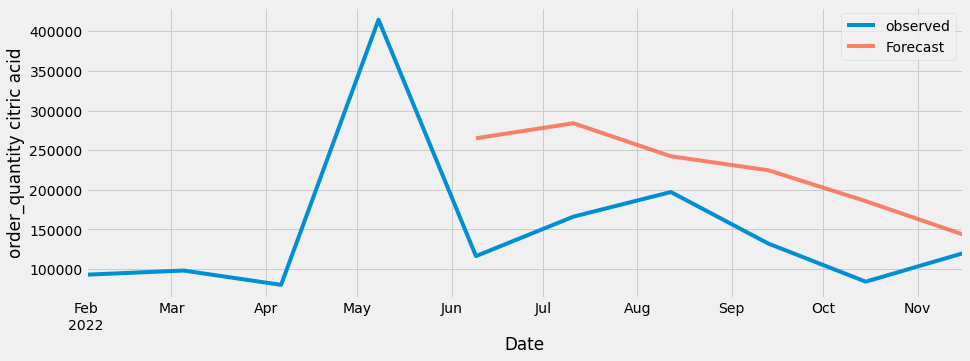

In [330]:
#create a predictor from 
pred = results.get_prediction(start=pd.to_datetime('2022-06-09'), dynamic=False, 
                              exog=df_citric['citric_inflation_lagged'],
                             )
ax = df_citric['order_quantity']['2022-02-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 5))
ax.set_xlabel('Date')
ax.set_ylabel('order_quantity citric acid')
plt.legend()
plt.show()

In [331]:
#evaluate the accuracy of the model since 2017 - 2020
y_forecasted = pred.predicted_mean
y_truth = df_citric['order_quantity']['2022-06-09':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)), 'which is better than baseline model, could be better.' )

The Mean Squared Error of our forecasts is 9580395780.71
The Root Mean Squared Error of our forecasts is 97879.5 which is better than baseline model, could be better.


In [332]:
df_citric_predicted = pd.DataFrame([y_truth,y_forecasted]).T
df_citric_predicted.rename(columns={'predicted_mean':'citric_acid_predicted'}, inplace=True)
df_citric_predicted

,order_quantity,citric_acid_predicted
2022-06-09,116297.220,264989.369
2022-07-11,166071.480,283973.242
2022-08-12,197139.680,242272.921
2022-09-13,132122.485,224632.757
2022-10-15,84018.580,185635.747
2022-11-16,119986.030,143459.110


#### Gelatin

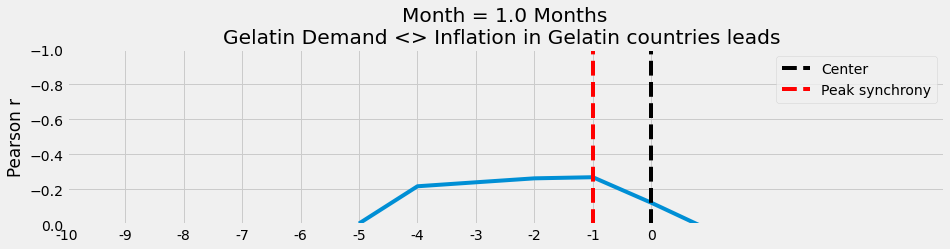

In [333]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df_gelatin['gelatin_inflation']
d2 = df_gelatin['order_quantity']

rs = [crosscorr(d1,d2, lag) for lag in range(-int(5),int(5))]
offset = np.floor(len(rs)/2)-np.argmin(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmin(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Month = {offset} Months\nGelatin Demand <> Inflation in Gelatin countries leads ',ylim=[0,-1],xlim=[0,10],ylabel='Pearson r')
ax.set_xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
# ax.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0]);
plt.legend()
plt.show()

From the above graph, can see that gelatin demand and inflation within countries that order gelatin is most correlated where there is a 2 month lag. Meaning gelatin is affected by price increases. Consumers tend to consume less when their purchasing power is less, hence the negative correlation of approximately -0.3. We will need to lag demand by 1 months when predicting gelatin for better performing model.

In [334]:
#As discussed above, create a new feature from lagging leading oil price by 5 months
df_gelatin['gelatin_inflation_lagged'] = df_gelatin['gelatin_inflation'].shift(1)
df_gelatin.dropna(inplace=True)

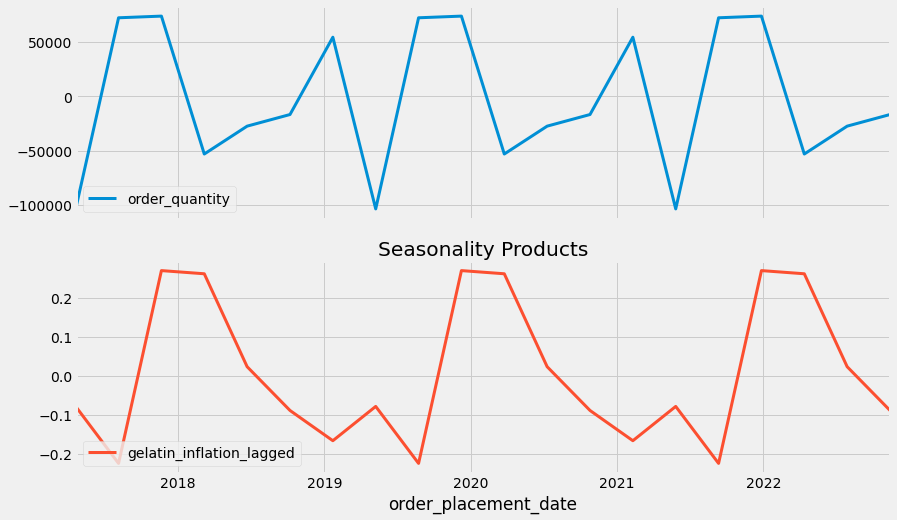

In [335]:
# visualize seasonality
seasonality_dict = {}

for demand in df_gelatin[['order_quantity','gelatin_inflation_lagged']].columns:
    decompositions = sm.tsa.seasonal_decompose(df_gelatin[demand] , model='additive')
    # Store the results back
    seasonality_dict[demand] = decompositions.seasonal
    

# Plot
plt.rcParams['figure.figsize'] = 13, 8
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(2, 1), linewidth=3,);
plt.title('Seasonality Products')
plt.show()

In [336]:
# Lagging the time series by 1, provide view just using past month as a predictor
df_base = pd.concat([df_gelatin['order_quantity'], df_gelatin['order_quantity'].shift(1)], axis=1)
df_base.columns = ['actual_demand', 'forecast_demand']
df_base.dropna(inplace=True)

from sklearn.metrics import mean_squared_error

# Use mean squared error to evaluate accuracy 
mse = ((df_base['actual_demand']['2021-12-27':] - df_base['forecast_demand']['2021-12-27':]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)), '. Let us proceed with alternative model')

The Mean Squared Error of our forecasts is 14988828139.56
The Root Mean Squared Error of our forecasts is 122428.87 . Let us proceed with alternative model


In [337]:
# Hyperparameter tuning to find best combination of orders to pass in the sarimax mode

import itertools

#using pcf & acf conclusions to create ranges 0 - 1
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]

In [338]:
#Hyperparameter tuning for SARIMAX using above mentioned opions. Select lowest AIC for particular run
# AIC - The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data.

d = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_gelatin['order_quantity'],
                                            exog=df_gelatin['gelatin_inflation_lagged'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            d.append({ 'Param': param,'Param_season': param_seasonal,'AIC': results.aic})
            options = pd.DataFrame(d)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 3)12 - AIC:569.132341574352
ARIMA(0, 0, 0)x(0, 0, 1, 3)12 - AIC:444.19420469629495
ARIMA(0, 0, 0)x(0, 1, 0, 3)12 - AIC:446.5771524948297
ARIMA(0, 0, 0)x(0, 1, 1, 3)12 - AIC:337.1530852486039
ARIMA(0, 0, 0)x(1, 0, 0, 3)12 - AIC:470.2559500783351
ARIMA(0, 0, 0)x(1, 0, 1, 3)12 - AIC:444.40120731392744
ARIMA(0, 0, 0)x(1, 1, 0, 3)12 - AIC:366.5050808864749
ARIMA(0, 0, 0)x(1, 1, 1, 3)12 - AIC:338.2721735049679
ARIMA(0, 0, 1)x(0, 0, 0, 3)12 - AIC:494.7270782156655
ARIMA(0, 0, 1)x(0, 0, 1, 3)12 - AIC:414.1417492116035
ARIMA(0, 0, 1)x(0, 1, 0, 3)12 - AIC:392.0283910472413
ARIMA(0, 0, 1)x(0, 1, 1, 3)12 - AIC:313.9041568526944
ARIMA(0, 0, 1)x(1, 0, 0, 3)12 - AIC:468.17283901052576
ARIMA(0, 0, 1)x(1, 0, 1, 3)12 - AIC:416.07113571111756
ARIMA(0, 0, 1)x(1, 1, 0, 3)12 - AIC:368.61372106279157
ARIMA(0, 0, 1)x(1, 1, 1, 3)12 - AIC:315.012708075331
ARIMA(0, 1, 0)x(0, 0, 0, 3)12 - AIC:510.16739319719335
ARIMA(0, 1, 0)x(0, 0, 1, 3)12 - AIC:397.45703974451914
ARIMA(0, 1, 0)x(0, 1, 0

In [339]:
#create object for best performing hyperparameters to capture lowest AIC scre from above
low_param = options[options.AIC == options.AIC.min()]['Param'].iloc[0]
low_param_season = options[options.AIC == options.AIC.min()]['Param_season'].iloc[0]

#Build SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df_gelatin['order_quantity'],
                                exog=df_gelatin['gelatin_inflation_lagged'],
                                order=low_param,
                                seasonal_order=low_param_season,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

#View model results
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    order_quantity   No. Observations:                   20
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 3)   Log Likelihood                -143.072
Date:                           Mon, 03 Apr 2023   AIC                            294.144
Time:                                   16:46:10   BIC                            295.736
Sample:                               04-20-2017   HQIC                           293.141
                                    - 11-13-2022                                         
Covariance Type:                             opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
gelatin_inflation_lagged  -3.52e+04   4.08e+04     -0.864      0.388   -1.15e+05    4.47e+04
m

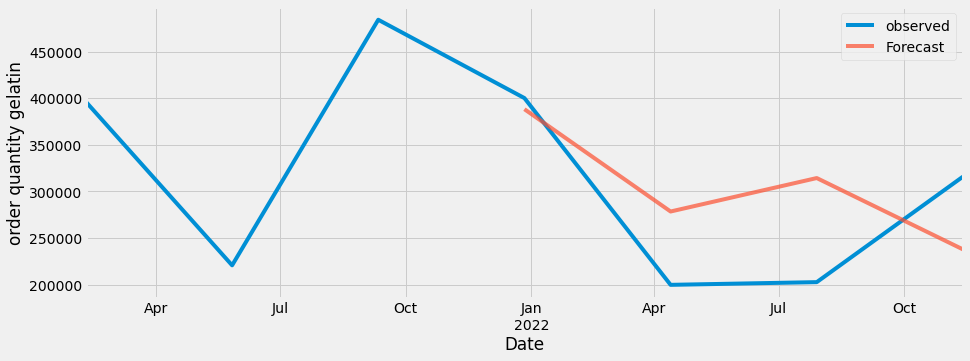

In [340]:
#create a predictor from 
pred = results.get_prediction(start=pd.to_datetime('2021-12-27'), dynamic=False, 
                              exog=df_gelatin['gelatin_inflation_lagged'] 
                             )
ax = df_gelatin['order_quantity']['2020-12-31':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 5))
ax.set_xlabel('Date')
ax.set_ylabel('order quantity gelatin')
plt.legend()
plt.show()

In [341]:
#evaluate the accuracy of the model since 2017 - 2020
y_forecasted = pred.predicted_mean
y_truth = df_gelatin['order_quantity']['2021-12-27':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)), 'which is better than baseline model, could be better.' )

The Mean Squared Error of our forecasts is 6214435287.45
The Root Mean Squared Error of our forecasts is 78831.69 which is better than baseline model, could be better.


In [342]:
df_gelatin_predicted = pd.DataFrame([y_truth,y_forecasted]).T
df_gelatin_predicted.rename(columns={'predicted_mean':'gelatin_predicted'}, inplace=True)
df_gelatin_predicted

,order_quantity,gelatin_predicted
2021-12-27,400122.141,388218.043
2022-04-13,199867.352,278504.372
2022-07-29,202771.647,314381.886
2022-11-13,315858.334,237913.435


### Sugar

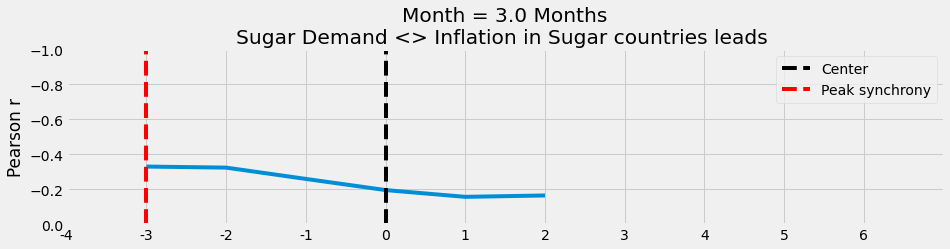

In [343]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df_sugar['sugar_inflation']
d2 = df_sugar['order_quantity']

rs = [crosscorr(d1,d2, lag) for lag in range(-int(0),int(6))]
offset = np.floor(len(rs)/2)-np.argmin(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmin(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Month = {offset} Months\nSugar Demand <> Inflation in Sugar countries leads ',ylim=[0,-1],xlim=[0,10],ylabel='Pearson r')
ax.set_xticks([-1,0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels([-4,-3,-2,-1,-0,1,2,3,4,5,6])
# ax.set_yticks([1,0.8,0.6,0.4,0.2,0]);
plt.legend()
plt.show()

From the above graph, we can estimate that demand and inflation periods are most correlated where there is a 3 period lag on  inflation. Much like gelatin, with a delining demand, this product seems to be the most sensitive to changes to inflation peaking at almost -0.4 pearson correlation. We can lag inflation on out model to better explain changes in demand for sugar.

In [344]:
#As discussed above, create a new feature from lagging leading oil price by 3 months
df_sugar['sugar_inflation_lagged'] = df_sugar['sugar_inflation'].shift(3)
df_sugar.dropna(inplace=True)

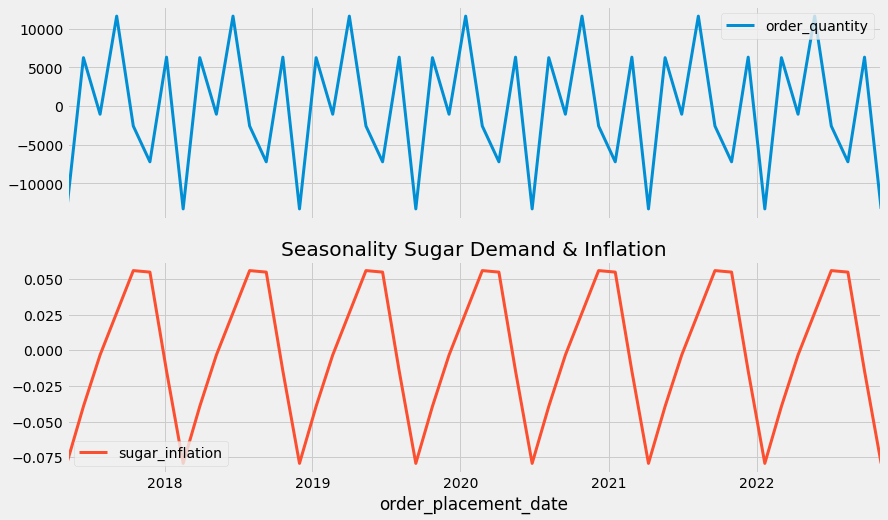

In [345]:
# visualize seasonality
seasonality_dict = {}

for demand in df_sugar[['order_quantity', 'sugar_inflation']].columns:
    decompositions = sm.tsa.seasonal_decompose(df_sugar[demand] , model='additive')
    # Store the results back
    seasonality_dict[demand] = decompositions.seasonal
    

# Plot
plt.rcParams['figure.figsize'] = 13, 8
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(2, 1), linewidth=3,);
plt.title('Seasonality Sugar Demand & Inflation')
plt.show()

In [346]:
# Lagging the time series by 1, provide view just using past month as a predictor
df_base = pd.concat([df_sugar['order_quantity'], df_sugar['order_quantity'].shift(1)], axis=1)
df_base.columns = ['actual_demand', 'forecast_demand']
df_base.dropna(inplace=True)

from sklearn.metrics import mean_squared_error

# Use mean squared error to evaluate accuracy 
mse = ((df_base['actual_demand']['2022-01-21':] - df_base['forecast_demand']['2022-01-21':]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)), '. Let us proceed with alternative model')

The Mean Squared Error of our forecasts is 718986152.45
The Root Mean Squared Error of our forecasts is 26813.92 . Let us proceed with alternative model


In [347]:
# Hyperparameter tuning to find best combination of orders to pass in the sarimax mode

import itertools

#using pcf & acf conclusions to create ranges 0 - 1
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 9) for x in list(itertools.product(p, d, q))]

In [348]:
#Hyperparameter tuning for SARIMAX using above mentioned opions. Select lowest AIC for particular run
# AIC - The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data.

d = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_sugar['order_quantity'],
                                            exog=df_sugar['sugar_inflation_lagged'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            d.append({ 'Param': param,'Param_season': param_seasonal,'AIC': results.aic})
            options = pd.DataFrame(d)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 9)12 - AIC:1341.0352405992332
ARIMA(0, 0, 0)x(0, 0, 1, 9)12 - AIC:966.7971879484504
ARIMA(0, 0, 0)x(0, 1, 0, 9)12 - AIC:1037.2946078580749
ARIMA(0, 0, 0)x(0, 1, 1, 9)12 - AIC:707.4407855394209
ARIMA(0, 0, 0)x(1, 0, 0, 9)12 - AIC:985.7349008597204
ARIMA(0, 0, 0)x(1, 0, 1, 9)12 - AIC:966.1897052951334
ARIMA(0, 0, 0)x(1, 1, 0, 9)12 - AIC:736.2591786824662
ARIMA(0, 0, 0)x(1, 1, 1, 9)12 - AIC:710.1304250779616
ARIMA(0, 0, 1)x(0, 0, 0, 9)12 - AIC:1156.740045692841
ARIMA(0, 0, 1)x(0, 0, 1, 9)12 - AIC:936.4767348018253
ARIMA(0, 0, 1)x(0, 1, 0, 9)12 - AIC:907.9915507065704
ARIMA(0, 0, 1)x(0, 1, 1, 9)12 - AIC:688.7473073824449
ARIMA(0, 0, 1)x(1, 0, 0, 9)12 - AIC:982.4013965226271
ARIMA(0, 0, 1)x(1, 0, 1, 9)12 - AIC:936.5730526910247
ARIMA(0, 0, 1)x(1, 1, 0, 9)12 - AIC:738.6229990588026
ARIMA(0, 0, 1)x(1, 1, 1, 9)12 - AIC:689.7611331605652
ARIMA(0, 1, 0)x(0, 0, 0, 9)12 - AIC:1277.0655100318927
ARIMA(0, 1, 0)x(0, 0, 1, 9)12 - AIC:920.3012244737466
ARIMA(0, 1, 0)x(0, 1, 0, 

In [349]:
#create object for best performing hyperparameters to capture lowest AIC scre from above
low_param = options[options.AIC == options.AIC.min()]['Param'].iloc[0]
low_param_season = options[options.AIC == options.AIC.min()]['Param_season'].iloc[0]

#Build SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df_sugar['order_quantity'],
                                exog=df_sugar['sugar_inflation_lagged'],
                                order=low_param,
                                seasonal_order=low_param_season,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

#View model results
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    order_quantity   No. Observations:                   50
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 9)   Log Likelihood                -334.044
Date:                           Mon, 03 Apr 2023   AIC                            676.088
Time:                                   16:46:14   BIC                            681.557
Sample:                               05-05-2017   HQIC                           677.800
                                    - 11-04-2022                                         
Covariance Type:                             opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
sugar_inflation_lagged -1.963e+04   2.22e+04     -0.886      0.376    -6.3e+04    2.38e+04
ma.L1  

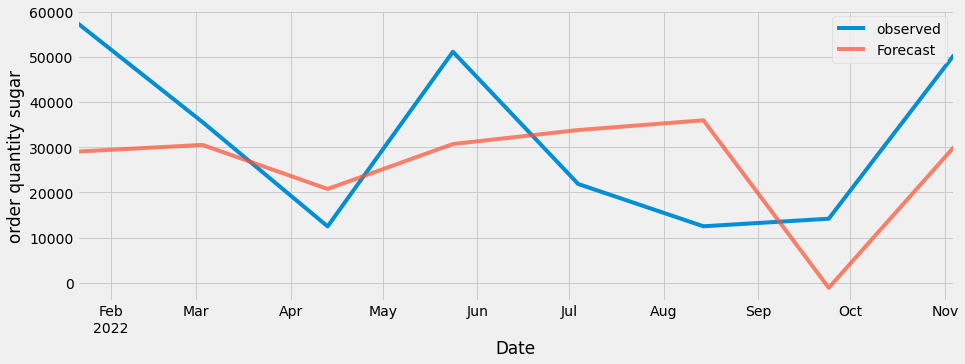

In [350]:
#create a predictor from 
pred = results.get_prediction(start=pd.to_datetime('2022-01-21'), dynamic=False, 
                              exog=df_sugar['sugar_inflation_lagged'] 
                             )
ax = df_sugar['order_quantity']['2022-01-21':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 5))
ax.set_xlabel('Date')
ax.set_ylabel('order quantity sugar')
plt.legend()
plt.show()

In [351]:
#evaluate the accuracy of the model since 2017 - 2020
y_forecasted = pred.predicted_mean
y_truth = df_sugar['order_quantity']['2022-01-21':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)), 'which is better than baseline model, could be better.' )

The Mean Squared Error of our forecasts is 334134024.47
The Root Mean Squared Error of our forecasts is 18279.33 which is better than baseline model, could be better.


In [352]:
df_sugar_predicted = pd.DataFrame([y_truth,y_forecasted]).T
df_sugar_predicted.rename(columns={'predicted_mean':'sugar_predicted'}, inplace=True)
df_sugar_predicted

,order_quantity,sugar_predicted
2022-01-21,57600.000,29045.070
2022-03-03,35625.000,30535.495
2022-04-13,12475.000,20766.451
2022-05-24,51175.000,30723.855
2022-07-04,21875.000,33827.246
2022-08-14,12500.000,35979.987
2022-09-24,14180.000,-1138.930
2022-11-04,50476.108,30081.206


In [ ]:
print(df_citric_predicted.reset_index())
print(df_gelatin_predicted.reset_index())
print(df_sugar_predicted.reset_index())
 
# create a excel writer object
with pd.ExcelWriter("_DS_assessment_Randy_Bukasa.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df_citric_predicted.reset_index().to_excel(writer, sheet_name="citric_acid", index=False)
    df_gelatin_predicted.reset_index().to_excel(writer, sheet_name="gelatin", index=False)
    df_sugar_predicted.reset_index().to_excel(writer, sheet_name="sugar", index=False)

        index  order_quantity  citric_acid_predicted
0  2022-06-09      116297.220             222586.243
1  2022-07-11      166071.480             202890.381
2  2022-08-12      197139.680             300010.957
3  2022-09-13      132122.485             257143.468
4  2022-10-15       84018.580             238484.401
5  2022-11-16      119986.030             155326.270
6  2022-12-18             NaN              78967.824
7  2023-01-19             NaN             -36351.471
8  2023-02-20             NaN             -32956.391
9  2023-03-24             NaN             -27480.706
10 2023-04-25             NaN             -82408.018
11 2023-05-27             NaN              99988.442
12 2023-06-28             NaN             -99878.251
13 2023-07-30             NaN             -68986.941
14 2023-08-31             NaN             -21850.969
15 2023-10-02             NaN             -51534.923
16 2023-11-03             NaN             -75226.863
17 2023-12-05             NaN             -791